In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import joblib

In [4]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images, images_test = list(), list()
    spots, spots_test = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = np.array(train_images[slide_name])
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = np.array(test_images[sample])
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images_test.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots_test.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = 0))
    # EfficientNet의 형식으로 바꿉니다.
    with tf.device('/CPU:0'):
        images = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images))
    df_spots = pd.concat(spots)
    with tf.device('/CPU:0'):
        images_test = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images_test))
    df_spots_test = pd.concat(spots_test)
    return images, df_spots, images_test, df_spots_test

def make_img_proc_info(df, img_with, img_height):
    """
    
    """
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )

def create_tf_ds(df):
    if (pd.Series(targets).isin(df.columns)).all():
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[targets])
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X, images):
    return tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    )

augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

images, df_spots, images_test, df_spots_test = load_data("data/elucidata_ai_challenge_data.h5")
targets = [i for i in df_spots.columns if i.startswith('C')]

target_proc = joblib.load('model/target_proc_2.joblib')

In [5]:
img_width = 224
img_height = 224

df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [12]:
m = joblib.load('model/eff_b0_2.joblib')

In [7]:
ds_train = create_tf_ds(df_spots).map(lambda X, Y: proc_images(X, images)).batch(32).prefetch(tf.data.AUTOTUNE).cache()
df_train_prd = pd.DataFrame(
    target_proc.inverse_transform(
        m.predict(ds_train)
    ), columns = targets
).reset_index().rename(columns = {'index': 'ID'})

261/261 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step


In [13]:
m.predict(ds_train)

261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step


array([[ 0.10017519,  0.08031461,  0.0177186 , ...,  0.22035986,
         0.17047517,  0.25091213],
       [ 0.4424919 ,  0.5165347 ,  0.3037264 , ..., -0.10271922,
         0.40597835,  0.46276098],
       [ 0.19498211,  0.064067  ,  0.07427815, ...,  0.13131942,
         0.20135194,  0.3699511 ],
       ...,
       [ 0.01174716, -0.00730362,  0.01096379, ...,  0.12569872,
         0.12128073,  0.26520005],
       [ 0.06826916,  0.29323816,  0.05722174, ...,  0.12854774,
         0.28707695,  0.49807405],
       [ 0.16138561,  0.15214978, -0.08584818, ...,  0.25624585,
         0.09795114,  0.32594597]], dtype=float32)

In [6]:
from scipy.stats import spearmanr

df_train_prd[targets].apply(
    lambda x: spearmanr(df_spots[x.name], x)
).loc[0]

<ipython-input-6-45fbf750c710>:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: spearmanr(df_spots[x.name], x)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


C1          NaN
C2          NaN
C3          NaN
C4          NaN
C5          NaN
C6          NaN
C7          NaN
C8          NaN
C9          NaN
C10         NaN
C11         NaN
C12         NaN
C13         NaN
C14   -0.038085
C15         NaN
C16         NaN
C17         NaN
C18         NaN
C19         NaN
C20         NaN
C21         NaN
C22         NaN
C23         NaN
C24         NaN
C25         NaN
C26         NaN
C27         NaN
C28         NaN
C29   -0.031202
C30         NaN
C31         NaN
C32         NaN
C33         NaN
C34         NaN
C35         NaN
Name: 0, dtype: float64

In [5]:
ds_test = create_tf_ds(df_spots_test).map(lambda X: proc_images(X)).batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [6]:
df_submission = pd.DataFrame(
    target_proc.inverse_transform(
        m.predict(ds_test)
    ), columns = targets
).reset_index().rename(columns = {'index': 'ID'})
df_submission.head()

66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step


,ID,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,0,0.028345,0.028936,0.023585,0.001592,0.159542,0.090689,0.009896,0.000644,0.310411,...,0.000767,0.160145,0.001880,0.003593,0.000033,0.030953,0.048167,0.001800,0.001303,0.018354
1,1,0.092172,0.036788,0.066752,0.005352,0.129100,0.022166,0.009946,0.000574,0.041530,...,0.000810,0.009187,0.000570,0.000688,0.000095,0.016491,0.021606,0.000446,0.001056,0.010087
2,2,0.031279,0.020999,0.023674,0.001906,0.006072,0.005735,0.001046,0.000137,0.044629,...,0.000507,0.009621,0.000347,0.000369,0.000053,0.011160,0.014157,0.000262,0.000328,0.003301
3,3,0.110869,0.069592,0.041550,0.000505,0.255251,0.414273,0.030925,0.001495,0.806643,...,0.001353,0.572239,0.005760,0.008945,0.000038,0.018840,0.044660,0.003319,0.001494,0.029568
4,4,0.124039,0.085628,0.079742,0.069164,0.214288,0.021450,0.037721,0.000604,0.028391,...,0.001351,0.012153,0.000440,0.001348,0.000019,0.107052,0.075979,0.000428,0.003532,0.048856


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

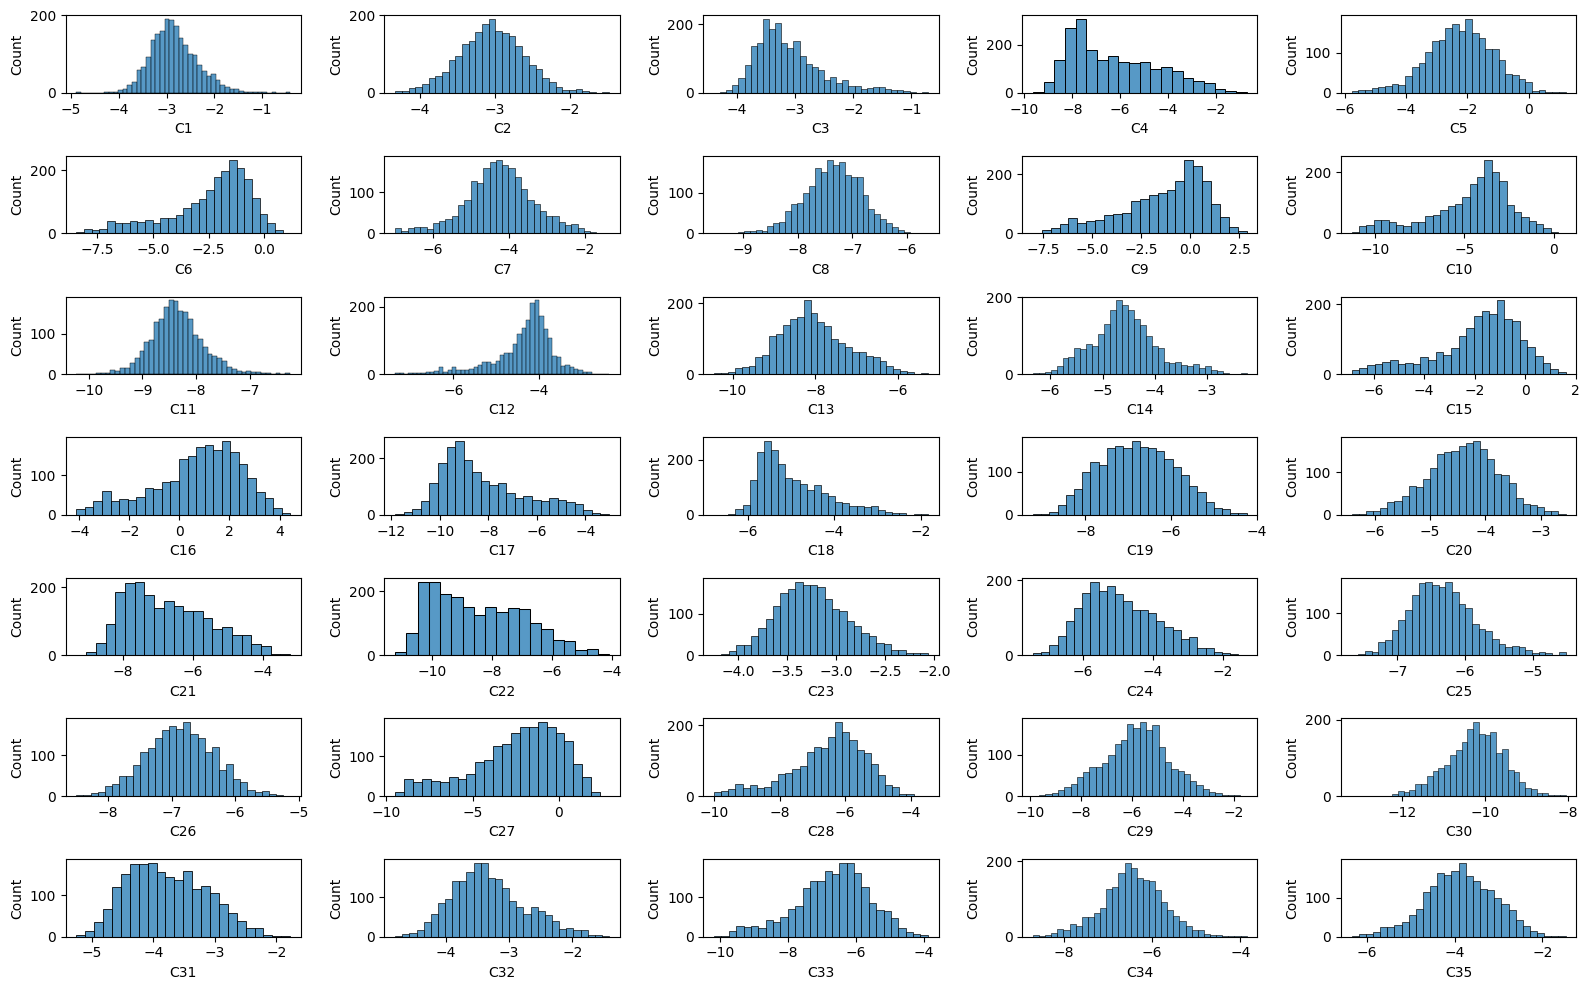

In [8]:
fig, axes = plt.subplots(7, 5, figsize = (16, 10))
for i, ax in zip(targets, axes.flatten()):
    sns.histplot(x = np.log(df_submission[i]), ax = ax)
plt.tight_layout()
plt.show()